## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

1A. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


1B. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

1C. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

1D. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

1E. The number of times the `new_page` and `treatment` don't match.

In [6]:
treatment_oldpage = df.query('group == "treatment" and landing_page != "new_page"').shape[0] 
control_newpage = df.query('group == "control" and landing_page != "old_page"').shape[0]
total = treatment_oldpage + control_newpage
print(total)

3893


1F. Check any of the rows have missing values.

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

1G. Remove the rows where the landing_page and group columns don't match and store the new dataframe in **df2**.

In [8]:
# pull rows where treatment matches with new_page
df2t = df.query('group == "treatment" and landing_page == "new_page"')

In [9]:
# pull rows where treatment matches with new_page
df2c = df.query('group == "control" and landing_page == "old_page"')

In [10]:
# join df2t and df2c
df2 = df2t.merge(df2c, how='outer')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

1H. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

1I. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.user_id.duplicated(keep=False)].user_id

938     773192
1404    773192
Name: user_id, dtype: int64

1J. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


1K. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates('user_id', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290584
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


1L. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

1M. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.converted[df2.group == 'control'].mean()

0.1203863045004612

1N. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.converted[df2.group == 'treatment'].mean()

0.11880806551510564

1O. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

**Consider the results from parts (1L) through (1O) above, there is insufficient evidence to conclude that the new treatment page leads to more conversions, because the conversion probabilities for both the control group and the treatment group are almost identical.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now,  I will consider myself need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?  I would state my hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{null}$**: **$p_{old}$** - **$p_{new}$** >= 0
<br>
**$H_{alternative}$**: **$p_{old}$** - **$p_{new}$** < 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  

2A. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

2B. What is the **conversion rate** for $p_{old}$ under the null?

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

2C. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2[df2.group == 'treatment'].count()[0]
n_new

145310

2D. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2.group == 'control'].count()[0]
n_old

145274

2E. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1-p_new])
new_page_converted.mean()

0.11960635881907646

2F. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1-p_old])
old_page_converted.mean()

0.11915415008879772

2G. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.00045220873027873587

2H. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process I used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
# bootstrapping
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted

In [28]:
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
obs_diff

-0.0015782389853555567

2I. Plot a histogram of the **p_diffs**

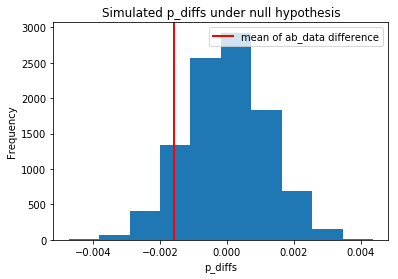

In [29]:
plt.hist(p_diffs)
plt.title('Simulated p_diffs under null hypothesis')
plt.ylabel('Frequency')
plt.xlabel('p_diffs')
plt.axvline(x=obs_diff, color='r', linewidth=2, label='mean of ab_data difference')
plt.legend();

2J. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
(p_diffs > obs_diff).mean()

0.91139999999999999

**The value calculated in part j is called p-value in scientific studies. P-value is the probability of observing the statistic (or one more extreme in favor of the alternative hypothesis) if the null hypothesis is true. Since the calculated p-value is much more significant than the stated Type I error rate of 5%, we failed to reject the null hypothesis. In other words, the new page is not better than the old page.**

2K. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. I will calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2[df2.group == 'control'].converted.sum()
convert_new = df2[df2.group == 'treatment'].converted.sum()
n_old = df2[df2.group == 'control'].converted.count()
n_new = df2[df2.group == 'treatment'].converted.count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


2L. Now use `stats.proportions_ztest` to compute my test statistic and p-value.  

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [33]:
# use the stated Type I error of 5% to calculate the required z score for rejecting the null hypothesis
from scipy.stats import norm
norm.ppf(1-(0.05/2))

1.959963984540054

**"The value of the z-score tells you how many standard deviations you are away from the mean. If a z-score is equal to 0, it is on the mean." (simplypsychology.org). The z score for a two-tail test with 5% alpha level can be calculated using Python or estimated from a z score table, and the result should be approximately 1.96. Since the z score of our dataset is lower than 1.96, we cannot reject the null hypothesis**

**The calculated p-value is very close to the p-value in part j, which leads to the same conclusion as shown above.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, I will see that the result I achieved in the A/B test in Part II above can also be achieved by performing regression.

**Since there will be only two outcomes, a logistic regression analysis is suitable for this case.**

3A. The goal is to use **statsmodels** to fit the logistic regression model, to see if there is a significant difference in conversion based on which page a customer receives. However, I first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  I will add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# add an intercept
df2['intercept'] = 1

# add ab_page column to convert the 'group' into 1s and 0s
df2[['ab_page_alt','ab_page']] = pd.get_dummies(df2['group'])

# use 'ab_page_control' as baseline
df2.drop(['ab_page_alt'], axis=1, inplace=True)

# check for data
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


3B. Use **statsmodels** to instantiate my regression model on the two columns you created in part b., then fit the model using the two columns I created in part **3A.** to predict whether or not an individual converts. 

In [35]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

3C. Provide the summary of my model below

In [36]:
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-30 21:56 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

3D. The p-value associated with **ab_page** differs from the value you found in **Part II**

**Hypothesis for Part II**
<br>
**$H_{null}$**: **$p_{old}$** - **$p_{new}$** ≥ 0
<br>
**$H_{alternative}$**: **$p_{old}$** - **$p_{new}$** < 0

**Hypothesis for Part III**
<br>
**$H_{null}$**: **$p_{old}$** - **$p_{new}$** = 0
<br>
**$H_{alternative}$**: **$p_{old}$** - **$p_{new}$** ≠ 0

**The p values are different because the hypothesis made for Part II and Part III are different. Part II is a one-tailed test, whereas Part III is a two-tailed test. The hypothesis in the logistic regression model only argues whether there is any relationship between the dependent and independent variables. The  hypothesis in Part II argues that if the new page is better than the old page. In Part II, the p-value indicates that the old page has the same or even better performance than the new page. In Part III, the p-value suggests that the ab_page is not statistically significant. To sum up, the conversion rate is not related to the pages that a user received.**

**There might be a few factors to consider for the regression model.**

**1. The time of day when the user uses the page may affect the conversion rate.**
<br>
**2. The loading time required for the website may affect the user experience. A user using the website with a higher internet speed may be more likely to convert.**
<br>
**3. The number of commercials on the website may affect the conversion rate.**
<br>
**4. The languages available on the page may also affect the conversion rate.**

**When adding new factors to the regression model, multicollinearity must be considered. Otherwise, the model may produce an inaccurate result.**

3E. To see if country had an impact on conversion, I will also add an effect based on which country a user lives in. I will read in the **countries.csv** dataset and merge together my datasets on the appropriate rows.

In [37]:
# read the countries.csv
countries_df = pd.read_csv('countries.csv')

# join both dataset together
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

# check on data
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
# check unique values for the country column
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
# create dummy columns for countries
df_new[['UK','US','CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [40]:
# fit regression model and use US as baseline
df_new['intercept'] = 1
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'CA']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-30 21:56 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
UK           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
CA           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
==================================================================

"""

In [41]:
1/np.exp(results.params)

intercept    7.292253
UK           1.052027
CA           1.009966
dtype: float64

**The inverse of the exponentiated coefficients shows that US users are only 1.052 times more likely to convert as compared to UK users and 1.01 times more likely to convert as compared to CA users. It can be concluded that the country does not have an impact on conversions. The corresponding p values for both UK and CA also suggest that countries are not statistically significant (p > 0.05).**

3F. Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.  I will create the necessary additional columns, and fit the new model.  

In [42]:
# create two additional columns to represent the interaction between page and country
df_new['UK_new'] = df_new['UK'] * df_new['ab_page']
df_new['CA_new'] = df_new['CA'] * df_new['ab_page']

In [46]:
# account pages for the model
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','UK_new','CA_new']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-30 22:17 AIC:              212777.1060
No. Observations:   290584           BIC:              212808.8450
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9873    0.0072  -275.5728  0.0000  -2.0014  -1.9732
UK_new       -0.0842    0.0378    -2.2251  0.0261  -0.1583  -0.0100
CA_new       -0.0197    0.0121    -1.6337  0.1023  -0.0434   0.0039
==================================================================

"""

In [47]:
1/np.exp(results.params)

intercept    7.295829
UK_new       1.087793
CA_new       1.019935
dtype: float64

**It can be concluded that the interaction between page and country does not have significant effects on conversion**

### Conclusion
**There is not enough evidence showing that the new page is better than the old page. The company can probably keep the old page. Moreiver, the logistic regression models suggest that neither country nor the interaction between page and country has significant effects on conversion.**

In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0